In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
from sklearn import cluster, datasets
from sklearn.preprocessing import StandardScaler
from matplotlib.lines import Line2D
import random
from bs4 import BeautifulSoup as bs4
import requests
from sklearn.metrics import silhouette_score
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
from time import sleep
from random import randint
import time
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

In [3]:
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.by import By
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.common.keys import Keys


### making clusters

In [4]:
data = pd.read_csv("songlists.csv")
data = data.dropna()
X = data.select_dtypes(include=np.number)

In [5]:
scaler = StandardScaler().fit(X)
X_pred = scaler.transform(X)

In [33]:
for i in range(2,14):
    print(pca.explained_variance_ratio_[:i].sum())

0.33335343367644155
0.42616856389044544
0.5114619835378919
0.5916392972681678
0.663553179191164
0.7345315129698566
0.7988664294027766
0.862239177894231
0.9198808898009339
0.9573167382091419
0.9859316102876612
0.9999999999999999


In [6]:
pca = PCA(10) # number of features
pca.fit(X_pred)
X_pred_pca = pca.transform(X_pred)

### find proper "k"

choose k

Text(0.5, 1.0, 'Elbow Method showing the optimal k')

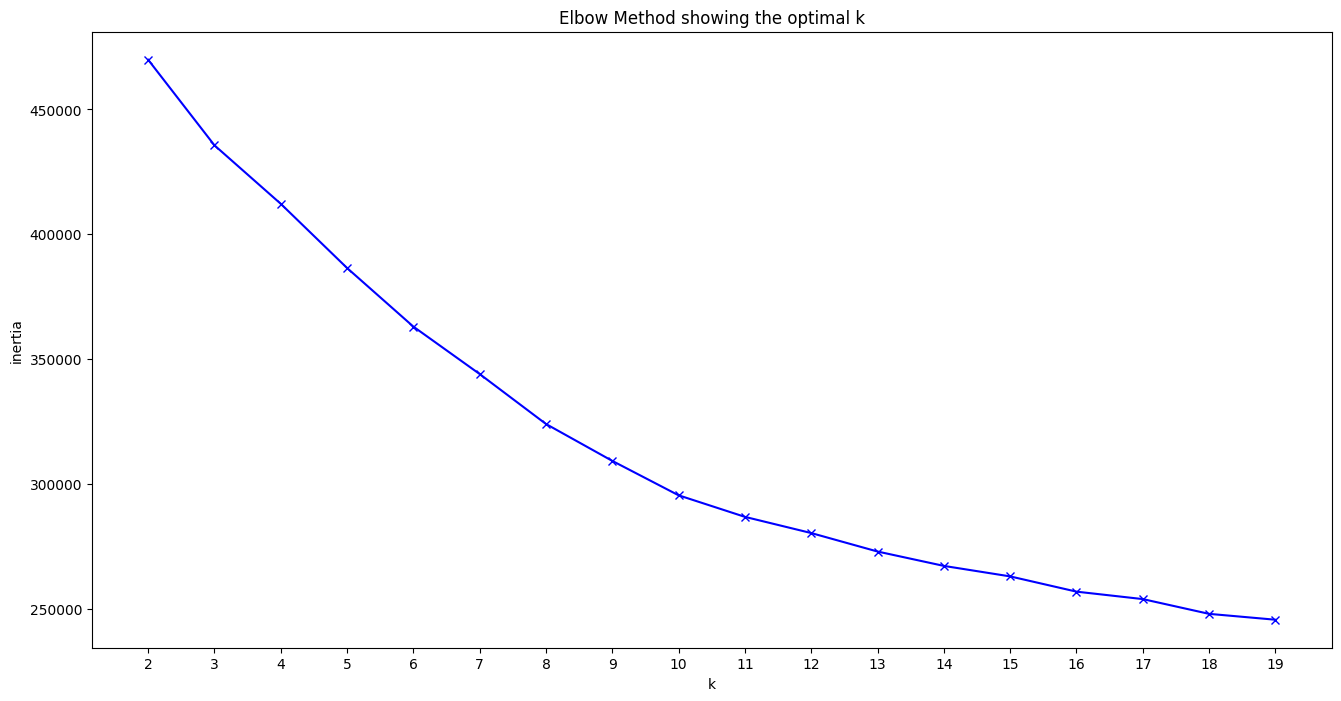

In [40]:
K = range(2, 20)
inertia = []

for k in K:
    kmeans = cluster.KMeans(n_clusters=k,
                    random_state=1234)
    kmeans.fit(X_pred)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(16,8))
plt.plot(K, inertia, 'bx-')
plt.xlabel('k')
plt.ylabel('inertia')
plt.xticks(np.arange(min(K), max(K)+1, 1.0))
plt.title('Elbow Method showing the optimal k')

Text(0.5, 1.0, 'Slhouette score showing the optimal k')

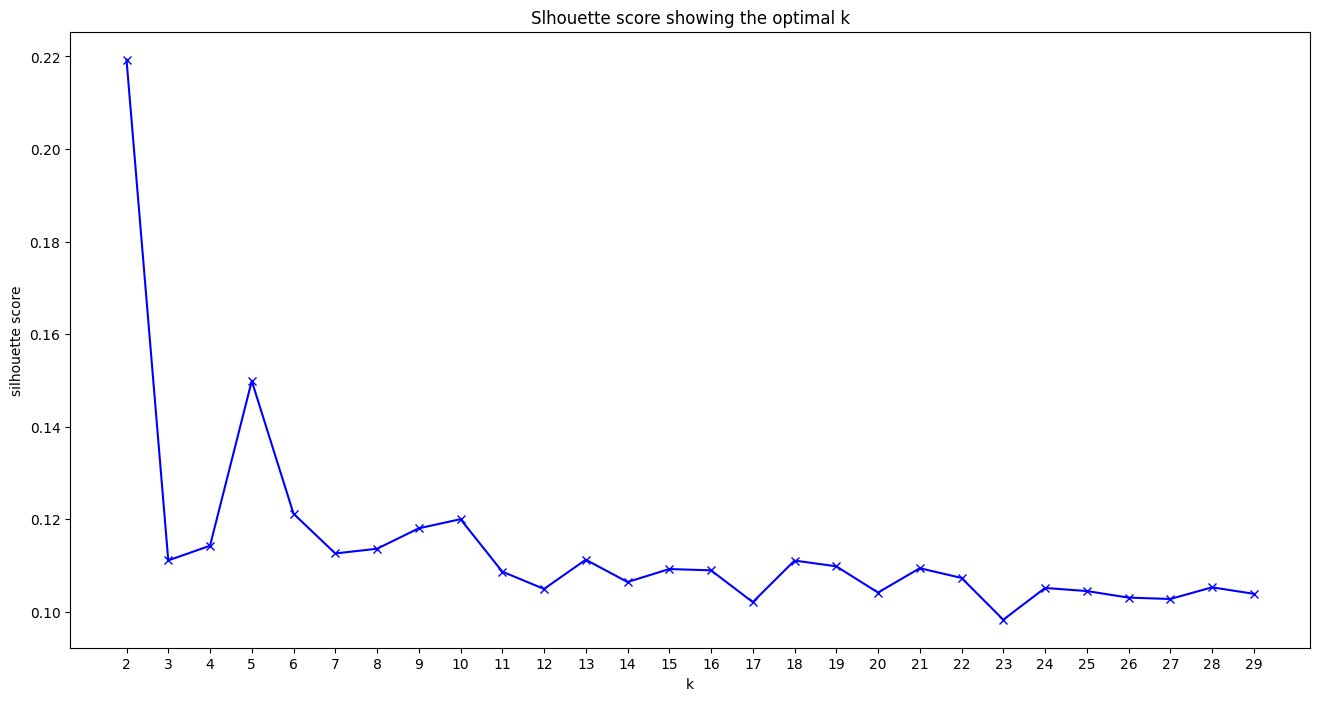

In [42]:
K = range(2, 30)
silhouette = []

for k in K:
    kmeans = cluster.KMeans(n_clusters=k,
                    random_state=1234)
    kmeans.fit(X_pred)
    silhouette.append(silhouette_score(X_pred, kmeans.predict(X_pred)))

plt.figure(figsize=(16,8))
plt.plot(K, silhouette, 'bx-')
plt.xlabel('k')
plt.ylabel('silhouette score')
plt.xticks(np.arange(min(K), max(K)+1, 1.0))
plt.title('Slhouette score showing the optimal k')

### continue with the work

In [15]:
kmeans = cluster.KMeans(n_clusters=1000)
kmeans.fit(X_pred)
pred = kmeans.predict(X_pred).tolist()

### checking actual top 100 songs

In [8]:
url = "https://www.popvortex.com/music/charts/top-100-songs.php"
response = requests.get(url)
contents = response.content
soup = bs4(contents, "html.parser")

In [9]:
result = soup.find("div",{"class":"chart-wrapper"})
titles = []
artists = []
for i in range(1,101,1):
    i_id = "chart-position-" + str(i)
    try:
        song = result.find("div",{"id":i_id})
        title = song.find("p",{"class":"title-artist"}).find("cite").text
        artist = song.find("p",{"class":"title-artist"}).find("em").text
        titles.append(title)
        artists.append(artist)
    except:
        pass
top100 = pd.DataFrame({"title":titles,"artist":artists})
top100.head()

,title,artist
0,Flowers,Miley Cyrus
1,"Shakira: Bzrp Music Sessions, Vol. 53",Bizarrap & Shakira
2,VIBE (feat. Jimin of BTS),TAEYANG
3,Unholy,Sam Smith & Kim Petras
4,Anti-Hero,Taylor Swift


### get random item from pool

In [10]:
def getrandom(df):
    x = df.shape[0]
    x = random.randint(0,x)
    rec_title = df.iloc[x,0]
    rec_artist = df.iloc[x,1]
    return rec_title, rec_artist

### getting songinfo from spotify

In [11]:
secrets_file = open("secrets.txt","r")
string = secrets_file.read()
secrets_dict={}
for line in string.split('\n'):
    if len(line) > 0:
        secrets_dict[line.split(':')[0]]=line.split(':')[1].strip()

sp = spotipy.Spotify(auth_manager=SpotifyClientCredentials(client_id=secrets_dict['clientid'],
                                                           client_secret=secrets_dict['clientsecret']))

In [12]:
def getsonginfo(t,a):
    track = sp.search(q=t+" "+a, limit=1)
    title = track["tracks"]["items"][0]["name"]
    artist = []
    artists = track["tracks"]["items"][0]["artists"]
    for i in artists:
        artist_n = i["name"]
        artist.append(artist_n)
    artist = ", ".join(artist)
    uri = track["tracks"]["items"][0]["uri"]
    songinfo = {"title":title, "artist":artist, "uri":uri}
    songinfo = pd.DataFrame(songinfo, index = [0])
    songuri = sp.audio_features(uri)
    songuri = pd.DataFrame(songuri)
    df = pd.concat([songinfo, songuri], axis = 1)
    return df

def getfromcluster(t,a, data):
    df = getsonginfo(t,a)
    x = df.select_dtypes(include=np.number)
    # x = x[[cols]]
    x_prep = scaler.transform(x)
    pred = kmeans.predict(x_prep)
    selection = data[data.cluster == pred[0]]
    title, artist = getrandom(selection)
    return title, artist

### getting recommendation(s)

In [18]:
t = input("type in one of your favorite song: ").lower()
a = input("type in the name of the artist: ").lower()
reactions = ["Nice one!","Great choice!","Not bad!","Interesting!","Cool!"]

title, artist = getrandom(top100)
recommend = False
if top100["title"].str.contains(t).any() or top100["artist"].str.contains(a).any():
    comment = random.choice(reactions)
    print(comment, "Maybe you'll like this song:\n\n" + title.title() + ", by", artist.title())
else:
    recommend = True
    print("Oh I think I know that one! That's a good choice for music.")
if recommend:
    data["cluster"] = pred
    rec_title, rec_artist = getfromcluster(t,a,data)
    print("\nYou might like this song:\n\n" + rec_title + ", by", rec_artist)
    print("\n...Not to your liking? Get more song recommendations! (run this cell again)")
    time.sleep(3)
    url = "https://www.youtube.com/"
    # --disabling browser popup notifications--
    options = Options()
    options.add_argument("--disable-notifications")
    # to prevent from being spotted as a robot
    options.add_argument('--disable-gpu')
    options.add_argument('user-agent=fake-useragent')
    # installing chromedriver, so that we dont need to keep the chromedriver file
    # that needs to be updated every once in a while. better install the latest automatically
    driver = webdriver.Chrome(ChromeDriverManager().install())
    # opens the browser, maximize window size
    driver.maximize_window()
    # opening url
    driver.get(url)
    # wait a bit until the "I accept" popup shows
    time.sleep(2)
    try:
        decline_x = "/html/body/ytd-app/ytd-consent-bump-v2-lightbox/tp-yt-paper-dialog/div[4]/div[2]/div[6]/div[1]/ytd-button-renderer[1]/yt-button-shape/button"
        decline = driver.find_element(By.XPATH, decline_x)
        decline.click()
        time.sleep(2)
    except:
        pass
    search_x = "/html/body/ytd-app/div[1]/div/ytd-masthead/div[3]/div[2]/ytd-searchbox/form/div[1]/div[1]/input"
    search = driver.find_element(By.XPATH, search_x)
    search.send_keys(rec_title + " " + rec_artist)
    time.sleep(1)
    search_button_x = "/html/body/ytd-app/div[1]/div/ytd-masthead/div[3]/div[2]/ytd-searchbox/button"
    search_button = driver.find_element(By.XPATH, search_button_x)
    search_button.click()
    time.sleep(1)
    first_x = "/html/body/ytd-app/div[1]/ytd-page-manager/ytd-search/div[1]/ytd-two-column-search-results-renderer/div/ytd-section-list-renderer/div[2]/ytd-item-section-renderer/div[3]/ytd-video-renderer[1]/div[1]/ytd-thumbnail/a/yt-image/img"
    first = driver.find_element(By.XPATH, first_x)
    first.click()
    time.sleep(1)

Oh I think I know that one! That's a good choice for music.

You might like this song:

How Does A Moment Last Forever, by Céline Dion

...Not to your liking? Get more song recommendations! (run this cell again)


C:\Users\mdima\AppData\Local\Temp\ipykernel_14524\2116107814.py:28: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  driver = webdriver.Chrome(ChromeDriverManager().install())
